In [121]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc3 as pm
import arviz as az

sns.set()

In [122]:
df = pd.read_csv('Howell1.csv',sep=';')
df.head()


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


In [123]:
df['sex'] = df['male'].apply(lambda x : 1 if x else 2)

religions = ['Christian','Muslim','Buddist','Jew']

df['religion'] =  np.random.choice(religions,replace=True,size=len(df),p=[0.25,0.50,0.15,0.10])

#### create an index for a multivalued category ####
df['rel'] = df['religion'].apply(lambda x : religions.index(x) + 1)

df = df[df['age'] > 18]
df

,height,weight,age,male,sex,religion,rel
0,151.765,47.825606,63.0,1,1,Buddist,3
1,139.700,36.485807,63.0,0,2,Christian,1
2,136.525,31.864838,65.0,0,2,Jew,4
3,156.845,53.041915,41.0,1,1,Muslim,2
4,145.415,41.276872,51.0,0,2,Muslim,2
...,...,...,...,...,...,...,...
534,162.560,47.031821,27.0,0,2,Muslim,2
537,142.875,34.246196,31.0,0,2,Muslim,2
540,162.560,52.163080,31.0,1,1,Christian,1
541,156.210,54.062496,21.0,0,2,Jew,4


In [124]:
def regression (cat1,x1,y):
    
    model = pm.Model()
    
    with model:
    
        x1 = x1.copy()
        a_mu = pm.Uniform('a_mu',0,2)
        a_sigma = pm.Uniform('a_sigma',0,2)

        a_cat1 = pm.Normal('a_cat1',a_mu,sd=a_sigma,shape=2)
        beta1 = pm.Normal('beta1',0,sd=1)
        obs_sigma = pm.Uniform('obs_sigma',0,1)

        
        
        linreg = a_cat1[cat1-1] + beta1 * x1

        obs = pm.Normal('obs',mu=linreg, sd=obs_sigma,observed=y)


        trace = pm.sample(5000,tune=1000,target_accept=0.90,chains=4,cores=4)

        a_mu_post = trace['a_mu'][:]
        a_mu_sigma_post = trace['a_sigma'][:]
        a_cat1_1_post = trace['a_cat1'][:,0]
        a_cat1_2_post = trace['a_cat1'][:,1]
        beta1_post_1 = trace['beta1'][:]
        obs_sigma_post = trace['obs_sigma'][:]

        result = pd.DataFrame({'a_mu_post' : a_mu_post,
                             'a_mu_sigma_post' : a_mu_sigma_post,
                             'a_cat1_1_post' : a_cat1_1_post,
                             'a_cat1_2_post' : a_cat1_2_post,
                             'beta1_post_1' : beta1_post_1,
                             'obs_sigma_post' : obs_sigma_post})
        
        _= az.plot_trace(trace)
        print (az.summary(trace,round_to=2))
    
    
        
        

        return result


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [obs_sigma, beta1, a_cat1, a_sigma, a_mu]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 31 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


           mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
a_cat1[0]  0.44  0.05    0.35     0.53        0.0      0.0  11972.10   
a_cat1[1] -0.40  0.05   -0.48    -0.31        0.0      0.0  13304.45   
beta1      0.53  0.03    0.47     0.60        0.0      0.0  11942.81   
a_mu       0.53  0.44    0.00     1.39        0.0      0.0  12744.68   
a_sigma    1.01  0.47    0.28     1.86        0.0      0.0   9133.02   
obs_sigma  0.56  0.02    0.52     0.60        0.0      0.0  15427.74   

             ess_sd  ess_bulk  ess_tail  r_hat  
a_cat1[0]  11931.14  11983.86  12449.57    1.0  
a_cat1[1]  13304.45  13306.72  12802.78    1.0  
beta1      11915.50  11951.78  12834.95    1.0  
a_mu       11209.08  11657.07   9205.35    1.0  
a_sigma     8048.37   9305.20   7501.21    1.0  
obs_sigma  15223.34  15805.75  11931.84    1.0  


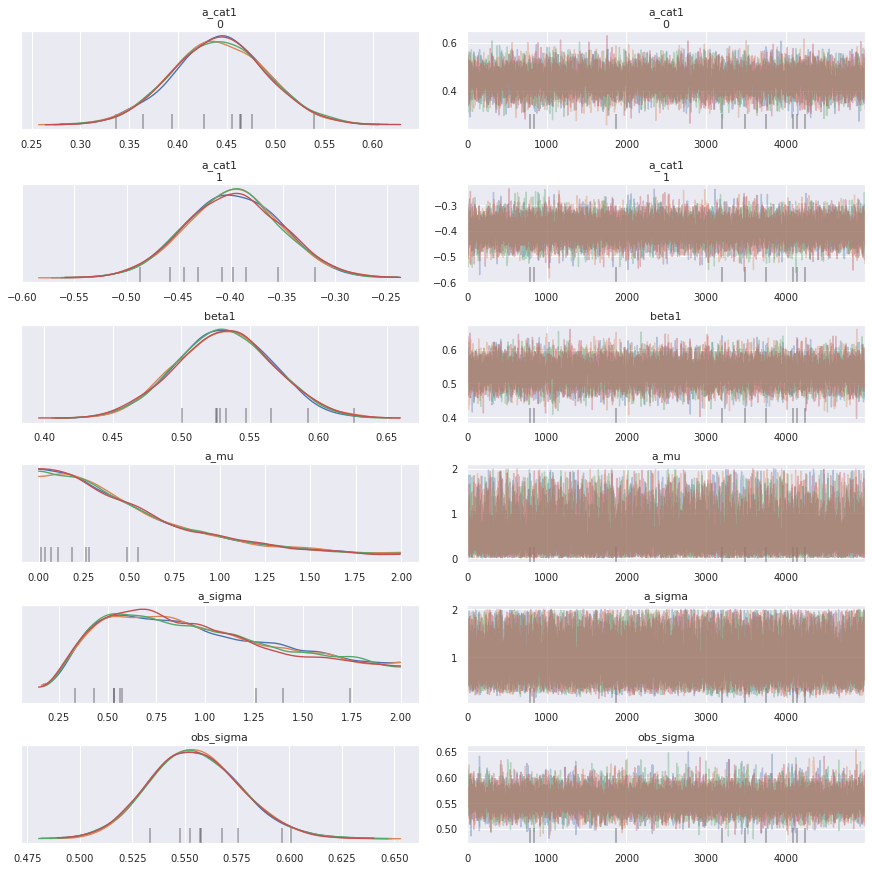

In [125]:
def standardize(x):
    return (x - x.mean()) / x.std()

df[['weight','age','height']] = df[['weight','age','height']].apply(standardize)
result = regression (df['sex'],df['weight'],df['height'])

In [126]:
print (result.head())
result.describe()


   a_mu_post  a_mu_sigma_post  a_cat1_1_post  a_cat1_2_post  beta1_post_1  \
0   0.011270         1.365178       0.381436      -0.362959      0.513677   
1   0.018281         0.855634       0.456486      -0.390769      0.547478   
2   1.001424         0.876015       0.436794      -0.458535      0.496154   
3   0.309616         0.765425       0.508260      -0.397840      0.551776   
4   0.127185         0.577958       0.481092      -0.462797      0.465781   

   obs_sigma_post  
0        0.553229  
1        0.560352  
2        0.563413  
3        0.542281  
4        0.567447  


,a_mu_post,a_mu_sigma_post,a_cat1_1_post,a_cat1_2_post,beta1_post_1,obs_sigma_post
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,0.527377,1.006840,0.442621,-0.396985,0.531907,0.555450
std,0.438837,0.466234,0.048148,0.045391,0.034962,0.021631
min,0.000029,0.146890,0.257297,-0.584453,0.396108,0.480325
25%,0.186867,0.618830,0.410288,-0.428001,0.508200,0.540602
50%,0.406784,0.941366,0.442561,-0.396935,0.531814,0.554549
75%,0.755686,1.363555,0.474708,-0.366562,0.555295,0.569400
max,1.998590,1.999619,0.628419,-0.236627,0.660146,0.653061


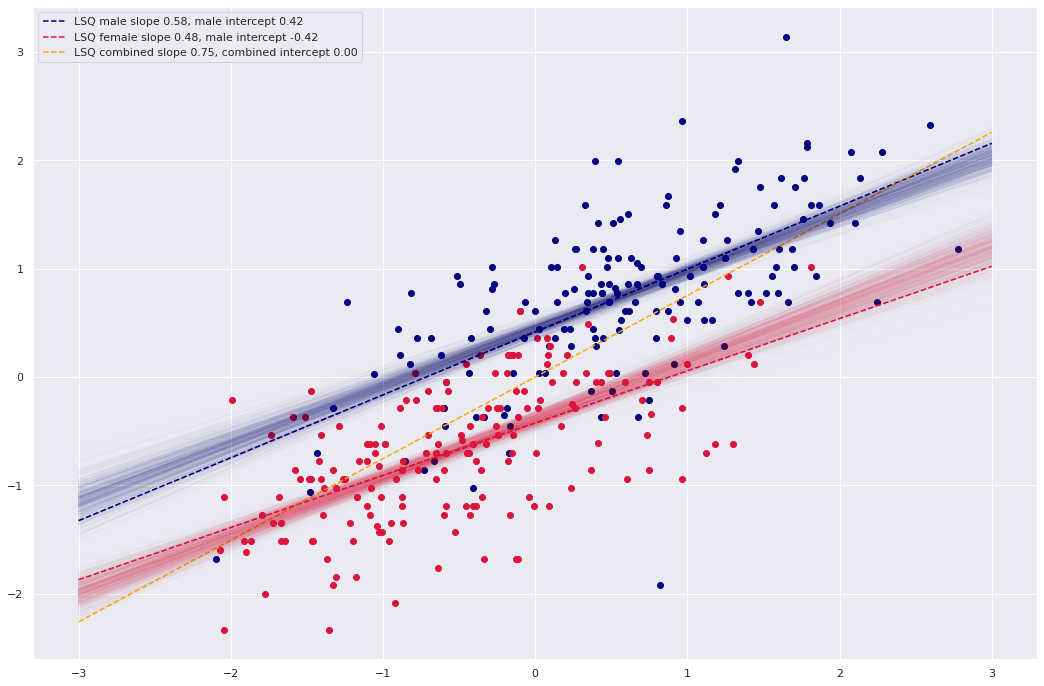

In [127]:
import scipy.stats as sps

plt.figure(figsize=(18,12))

males = df[ df['sex'] == 1]
females = df[df['sex'] == 2]

plt.scatter(males.weight,males.height,color='navy')
plt.scatter(females.weight,females.height,color='crimson')

male_slope,male_intercept,_,_,_ = sps.linregress(males.weight,males.height)
female_slope,female_intercept,_,_,_ = sps.linregress(females.weight,females.height)
combined_slope,combined_intercept,_,_,_ = sps.linregress(df.weight,df.height)

X = np.linspace(-3,3,100)

plt.plot(X,X * male_slope + male_intercept, 
         color='navy',
         ls='dashed',
         label='LSQ male slope {:.2f}, male intercept {:.2f}'.format(male_slope,male_intercept))
         
plt.plot(X,X * female_slope + female_intercept, 
         color='crimson',
         ls='dashed',
         label='LSQ female slope {:.2f}, male intercept {:.2f}'.format(female_slope,female_intercept))

plt.plot(X,X * combined_slope + combined_intercept, 
         color='orange',
         ls='dashed',
         label='LSQ combined slope {:.2f}, combined intercept {:.2f}'.format(combined_slope,combined_intercept))
         
plt.legend(loc='upper left')

nr_rows = 500

sample_rows = np.random.choice(result.index,replace=True,size=nr_rows)

a_cat1_1_samples = result.iloc[sample_rows].a_cat1_1_post
a_cat1_2_samples = result.iloc[sample_rows].a_cat1_2_post
beta1_1_samples = result.iloc[sample_rows].beta1_post_1

lines_male = np.array([X[i] * beta1_1_samples  + \
                  a_cat1_1_samples  for i in range(len(X))])

lines_female = np.array([X[i] * beta1_1_samples  + \
                  a_cat1_2_samples  for i in range(len(X))])




_= plt.plot(X,lines_male,color='navy',alpha=0.01)

_= plt.plot(X,lines_female,color='crimson',alpha=0.01)




